----------------------------
# Exercise 1.2


In [143]:
# file imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.optimize import minimize as minimize
import time
import random
import itertools
import copy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook
from itertools import combinations

In [144]:
# splitting data in train test and val set
def data_split(data, val = True):
    
    X = np.array(data.iloc[:,:2])
    y = np.array(data.iloc[:, 2])
    
    # train-val split 100% -> 70% - 30%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1) 
    
    if val == False:
        return X_train.T, X_val.T, y_train, y_val
    
    else:
    # val-test split 30% -> 15% - 15%
        X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=1)
        return X_train.T, X_test.T, X_val.T, y_train, y_test, y_val


data = pd.read_excel(r'C:\Users\RE-Giorgio\Downloads\dataPoints.xlsx')
random.seed(1696991)
X_train, X_test, X_val, y_train, y_test, y_val = data_split(data)


In [145]:
# common class for shallow neural newtworks with 1 output node
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.c = self.X.T[np.random.randint(self.X.shape[1], size=self.N),:]
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.X.shape[0], self.N), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(2)]))
        c, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(2)]
        return c, v
    
    # objective function to minimize
    def loss(self,params):
        
        c, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, c, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, c, v):
        return 0.5 * np.mean(np.square(self.predict(X, c, v) - y)) 

# Mlp inherits the general charectiristics of a shallow nn 
class Rbf(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def phi(self, x, c):
        
        x_c = np.stack([x.T]*self.N) - np.split(c.T, self.N)
        phi = np.exp(-np.square(np.array([np.linalg.norm(arr, axis = 1) for arr in (x_c)])/self.sigma))

        return phi
    
    def predict(self, x, c, v):

        H = self.phi(x, c)
        self.output = v @ H
        return self.output
    
    def c_der(self, c):
        
        
        x_c = (np.stack([self.X.T]*self.N) - np.split(c.T, self.N))
        der = -2* x_c/np.square(self.sigma)
        phi = np.stack([ self.gaussian(np.array([np.linalg.norm(arr, axis = 1)
                                                  for arr in x_c]))]*2).reshape(self.N, self.X.shape[1],2)
        return  der * phi

    
    def gaussian(self, r):
        return np.exp(-np.square(r/self.sigma))

        
    def grad(self, params):
        
        c, v = self.separate(params)
        H = self.phi(self.X, c)
        f_x = v @ H
        
        dc1 = 2*self.rho*c[0,:] + np.mean(((self.X[0,:]-np.split(c[0,:].T, self.N))*
                                          (((f_x - self.y)*H)*((2/self.sigma**2)*v.T))), axis = 1)
        
        dc2 = 2*self.rho*c[1,:] + np.mean(((self.X[1,:]-np.split(c[1,:].T, self.N))*
                                          (((f_x - self.y)*H)*((2/self.sigma**2)*v.T))), axis = 1)
        
        dv = 2*self.rho*v.T + (1/self.X.shape[1]) * (H @ ((v @ H) - self.y).T)
        dc = np.concatenate([dc1, dc2])
        #print(dv.shape)
        return np.concatenate([array.reshape(-1) for array in [dc, dv]])
    
    # optimization of the objective function
    def optimize(self):
        
        inits = np.concatenate([array.reshape(-1) for array in [self.c, self.v]])
        
        print("training...", "\n")
        start = time.time()
        result =  minimize(self.loss, x0 = inits, method = self.method, jac = self.grad)
        time_elapsed = time.time() - start
        #print(result)
        print("finished training.")
        
        # optimal parameters
        self.c, self.v = self.separate(result.x)
        
        return result.nfev, result.njev, result.nit, result.fun, result.jac, time_elapsed


In [146]:

nn = Rbf(X_train, y_train, N = 30, sigma = 0.55, rho = 10e-5, method = "BFGS")
nfev, njev, nit, fun, jac, time_elapsed = nn.optimize()
print("Training Error :", nn.mse(X_train, y_train, nn.c, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.c, nn.v)) 


training... 

finished training.
Training Error : 0.007897813153637703
Test Error : 0.024477022608555332


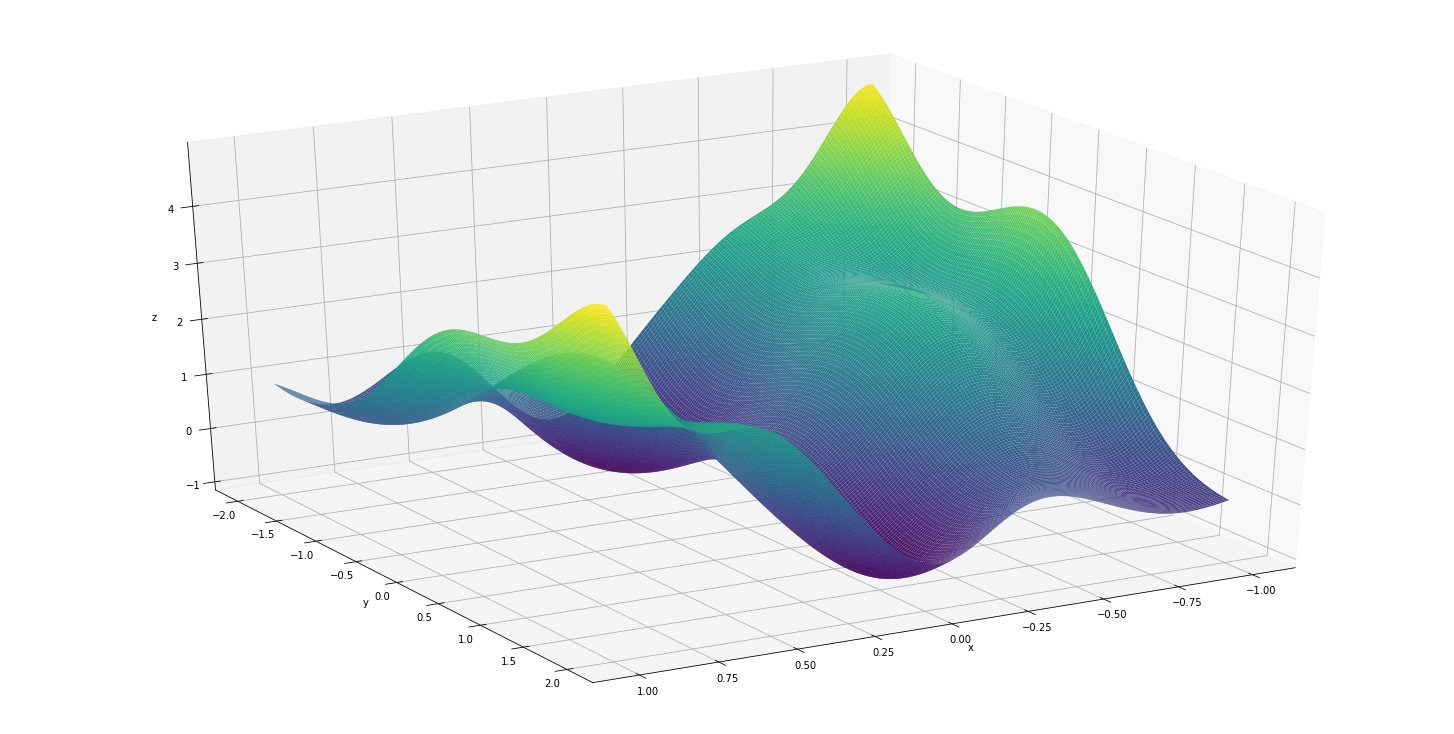

In [147]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure(figsize = [20,10])
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(-2, 2, 200)
    x2 = np.linspace(-1, 1, 200)
    X2, X1 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.c, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(30, 60)
    plt.show()
    
plot(nn)

In [94]:
param_grid = {"N" : [10, 15, 20, 25, 30], "sigma" : [0.1,0.5,0.7,1, 2, 5], "rho" : [10e-5], "method" : ["BFGS", "CG"]}

results = []
combinations = list(itertools.product(*param_grid.values()))
for comb in tqdm_notebook(combinations):
    
    
    print("current combination :", comb)
    print("\n")
    nn = Rbf(X_train, y_train, N = comb[0], sigma = comb[1], rho = comb[2], method = comb[3])
    nn.optimize()
    results.append(nn.mse(X_val, y_val, nn.c, nn.v))

current combination : (10, 0.1, 0.0001, 'BFGS')


training... 

finished training.
current combination : (10, 0.1, 0.0001, 'CG')


training... 

finished training.
current combination : (10, 0.5, 0.0001, 'BFGS')


training... 

finished training.
current combination : (10, 0.5, 0.0001, 'CG')


training... 

finished training.
current combination : (10, 0.7, 0.0001, 'BFGS')


training... 

finished training.
current combination : (10, 0.7, 0.0001, 'CG')


training... 

finished training.
current combination : (10, 1, 0.0001, 'BFGS')


training... 

finished training.
current combination : (10, 1, 0.0001, 'CG')


training... 

finished training.
current combination : (10, 2, 0.0001, 'BFGS')


training... 

finished training.
current combination : (10, 2, 0.0001, 'CG')


training... 

finished training.
current combination : (10, 5, 0.0001, 'BFGS')


training... 

finished training.
current combination : (10, 5, 0.0001, 'CG')


training... 

finished training.
current combination : (15, 0

In [95]:
combinations[results.index([min(results)])]

(30, 0.5, 0.0001, 'BFGS')

---------------
# Exercise 2.2


In [152]:
# common class for shallow neural newtworks with 1 output node
class ShallowNeuralNetwork:
    
    
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None, seed = 1):
        


        self.X = X
        self.y = y
        self.N = N
        np.random.seed(seed)
        self.c = self.X.T[np.random.randint(self.X.shape[1], size=self.N),:]
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method
        
    # clustering
    def pick_clusters(self, X):
        km = KMeans(n_clusters=self.N, init = "k-means++").fit(X.T)
        print(km.cluster_centers_.T)
        return km.cluster_centers_.T[0:2,:]

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.X.shape[0], self.N), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(2)]))
        c, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(2)]
        return c, v
    
    # objective function to minimize
    def loss(self,params):
        
        v = params
        return 0.5 * np.mean(np.square((self.predict(self.X, self.c, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(np.concatenate([array.reshape(-1) for array in [self.c, v]])))
    
    # metric for train and test accuracy
    def mse(self, X, y, c, v):
        return 0.5 * np.mean(np.square(self.predict(X, c, v) - y)) 

# Mlp inherits the general charectiristics of a shallow nn 
class Rbf_el(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def phi(self, x, c):
        x_c = np.stack([x.T]*self.N) - np.split(c, self.N)
        phi = np.exp(-np.square(np.array([np.linalg.norm(arr, axis = 1) for arr in (x_c)])/self.sigma))

        return phi
    
    def predict(self, x, c, v):

        H = self.phi(x, c)
        self.output = v @ H
        return self.output
    
    def grad(self, v):
        
        H = self.phi(self.X,self.c)
        dv = 2*self.rho*v + (1/self.X.shape[1]) * (H @ ((H.T @ v) - self.y).T )
        
        return dv
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = self.v
        
        #print("training...", "\n")
        start = time.time()
        result =  minimize(self.loss, x0 = inits, method = self.method, jac = self.grad)
        time_elapsed = time.time() - start
        #print(result)
        #print("finished training.")
        
        # optimal parameters
        self.v = result.x
        
        return result.nfev, result.njev, result.nit, result.fun, result.jac, time_elapsed


In [ ]:
# extreme  learning traning
print("training...", "\n")
start = time.time()
num_it = 1000

test_mses = {}
train_mses = {}
for i in tqdm_notebook(range(num_it)):
    
    s = np.random.randint(1000000000)
    nn = Rbf_el(X_train, y_train, N = 30, sigma = 0.5, rho = 10e-5, seed = s)
    nn.optimize()
    
    train_mses[s] = nn.mse(X_train, y_train, nn.c, nn.v)
    test_mses[s] = nn.mse(X_test, y_test, nn.c, nn.v)
    
time_elapsed = time.time() - start
print("finished training.")

opt_seed = min(test_mses, key=train_mses.get)
print("Train Error :", min(list(train_mses.values())))
print("Test Error :", min(list(test_mses.values())))# 0.03 538366619 # 0.0680456517089455 120111235
print("Seed :", opt_seed)

# seed = 729756269 NOT as disgustingly horrible plot

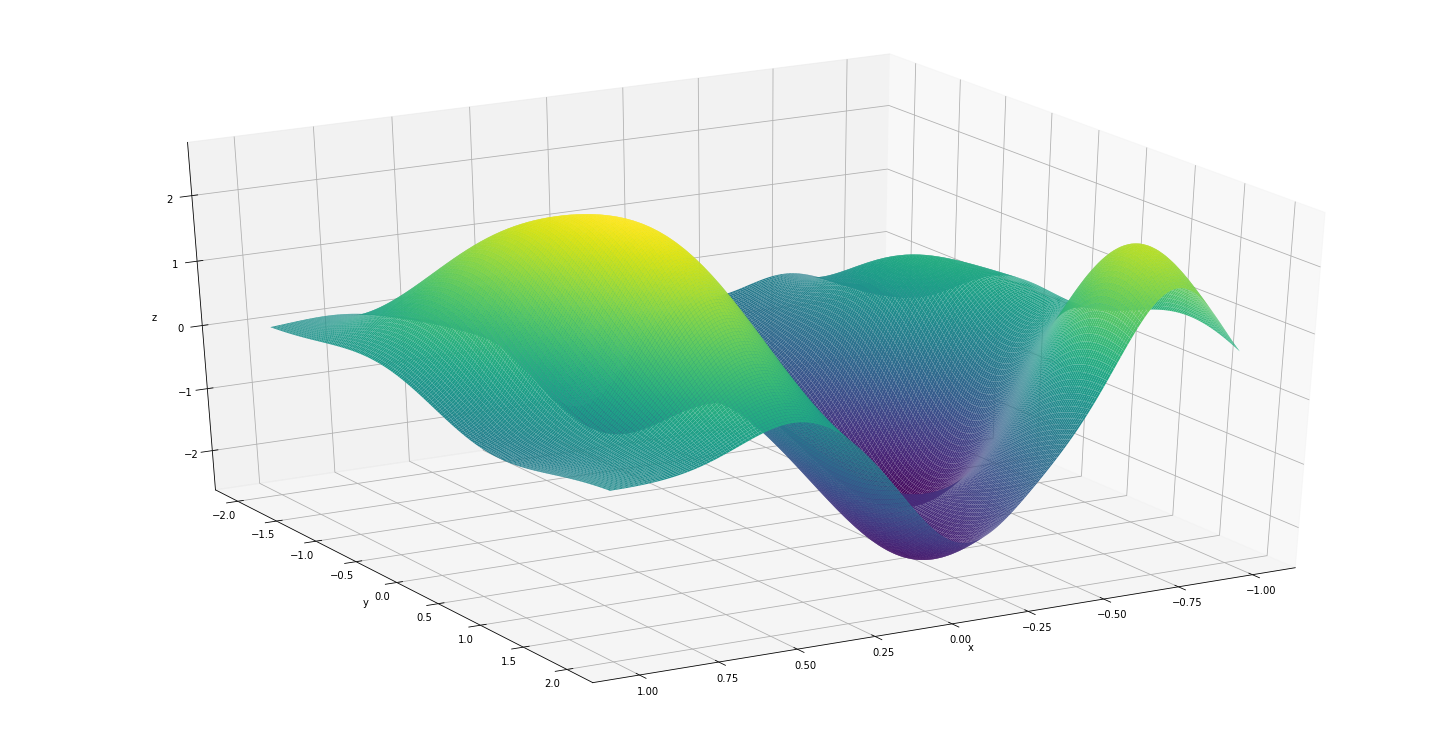

In [159]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure(figsize = [20,10])
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(-2, 2, 200)
    x2 = np.linspace(-1, 1, 200)
    X2, X1 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.c, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(30, 60)
    plt.show()
    

nn = Rbf_el(X_train, y_train, N = 30, sigma = 0.5, rho = 10e-5, seed = opt_seed)
plot(nn)